In [1]:
DATA_USED_IN_SUBMISSION = [
"NSL-12-353891",
"NSL-13-372448",
"NSL-15-419455",
"NSL-18-461627",
"NSL-20-508618",
"NSL-16-424330",
"NSL-17-427211",
"NSL-17-427426",
"NSL-17-427772",
"NSL-11-334467",
"NSL-19-498972",
"NSL-19-496932",
"NSL-20-507535",
"NSL-21-535052",
"NSL-21-538177",
"NSL-20-507154",
"NSL-20-516032",
"NSL-20-521393",
"NSL-21-528192",
"NSL-19-483887",
"NSL-22-546869",
"NSL-21-529372",
"NSL-20-525232(a)",
"NSL-20-525232(b)",
"NSL-20-518093",
"NSL-18-465938",
"NSL-19-486847",
"NSL-18-462834",
"NSL-16-421424",
"NSL-22-545835",
"NSL-19-480650",
"NSL-22-545099",
"NSL-19-468627",
"NSL-15-415616",
"NSL-15-417077",
"NSL-17-428937",
"NSL-15-419402 (b)",
"NSL-15-419402(a)",
"NSL-19-478371",
"NSL-17-429795",
"NSL-21-536932",
"NSL-21-538486",
"NSL-17-430196",
"NSL-19-482527",
"NSL-19-501598",
"NSL-14-384076",
"NSL-21-541560",
"NSL-19-486387",
"NSL-13-360551",
"NSL-16-425566",
"NSL-16-426958(a)",
"NSL-16-426958(b)",
"NSL-20-511736",
"NSL-20-520999",
"NSL-18-466427",
"NSL-20-520092",
"NSL-14-397674",
"NSL-15-419360",
"NSL-16-421621",
"NSL-16-422691",
"NSL-16-423572",
"NSL-21-536833",
"NSL-21-538669",
"NSL-21-541333",
"NSL-19-467961",
"NSL-19-489147",
"NSL-19-499001",
"NSL-19-499053",
"NSL-19-500032",
"NSL-11-342366",
"NSL-11-344313",
"NSL-20-523680",
"NSL-15-418095",
"NSL-11-338847",
"NSL-15-419223",
"NSL-13-362610",
"NSL-20-509094",
"NSL-19-494513",
"NSL-17-429683",
"NSL-15-413278",
"NSL-15-415945",
"NSL-16-426304",
"NSL-16-426311",
"NSL-16-426330",
"NSL-21-527897",
"NSL-20-509924",
"NSL-19-489668",
"NSL-19-501392",
"NSL-15-414420",
"NSL-19-499418",
"NSL-18-448908",
"NSL-18-455369",
"NSL-18-461230",
"NSL-14-398382",
"NSL-11-325536",
"NSL-12-349927",
"NSL-13-370091",
"NSL-13-376261",
"NSL-21-532552",
"NSL-19-472409",
"NSL-19-496252",
"NSL-17-431485",
"NSL-19-480569",
"NSL-13-377056",
"NSL-14-385446",
"NSL-12-357019",
"NSL-19-470447",
"NSL-12-346362",
"NSL-13-368998",
"NSL-17-435703",
"NSL-15-416625",
"NSL-17-434843",
"NSL-16-423497",
"NSL-20-508593",
"NSL-18-456329",
"NSL-18-462728",
"NSL-20-508552",
"NSL-19-473948",
"NSL-12-356022",
"NSL-12-357569",
"NSL-15-412886",
"NSL-17-432056",
"NSL-18-440140",
"NSL-18-440570",
"NSL-18-444387",
"NSL-19-471947",
"NSL-17-429459",
"NSL-17-430136",
"NSL-18-457728",
"NSL-18-458927",
"NSL-19-478589",
"NSL-15-420184",
"NSL-16-422320",
"NSL-16-420393",
"NSL-17-431338",
"NSL-19-479575",
"NSL-19-497253",
"NSL-20-511559",
"NSL-20-512880",
"NSL-18-448595",
"NSL-14-395697",
"NSL-18-466291",
"NSL-19-468088",
"NSL-20-507772",
"NSL-18-452187",
"NSL-19-480911",
"NSL-19-483160",
"NSL-15-416292",
"NSL-18-465610",
"NSL-18-467331",
"NSL-19-494620",
"NSL-18-451750",
"NSL-17-433599",
"NSL-19-476450",
"NSL-17-430862",
"NSL-17-430991",
"NSL-16-422740",
"NSL-15-408634(a)",
"NSL-15-408634(b)",
"NSL-18-452509",
"NSL-18-456527",
"NSL-17-431064",
"NSL-19-491952",
"NSL-18-445487",
"NSL-17-428087",
"NSL-13-376214",
"NSL-14-382702",
"NSL-16-421385",
"NSL-17-430092",
"NSL-18-460008",
"NSL-17-428084",
"NSL-17-428259",
"NSL-17-433391",
"NSL-17-427347",
"NSL-18-446688(a)",
"NSL-17-431346(a)",
"NSL-17-431346(b)",
"NSL-16-422213",
"NSL-16-425207",
"NSL-12-350364",
"NSL-18-447570",
"NSL-16-423127",
"NSL-18-450995",
"NSL-18-463687",
"NSL-18-466228",
"NSL-18-440331",
"NSL-16-422831",
"NSL-18-444528",
"NSL-13-363789",
"NSL-18-453727",
"NSL-15-419883",
"NSL-15-412703",
"NSL-16-424845",
"NSL-15-417904",
"NSL-17-431971(a)",
"NSL-17-431971(b)",
"NSL-17-433558",
"NSL-15-412214",
"NSL-15-420122",
"NSL-17-431900",
"NSL-14-382011",
"NSL-16-421854",
"NSL-14-404710",
"NSL-14-404670",
"NSL-14-394005",
"NSL-14-395338",
"NSL-14-395538",
"NSL-14-403866",
"NSL-13-363616",
"NSL-16-421359",
"NSL-16-421818",
"NSL-09-264375",
"NSL-15-417720",
"NSL-13-368476",
"NSL-13-371318",
"NSL-10-323210",
"NSL-14-392192",
"NSL-14-394627",
"NSL-13-370805",
"NSL-14-395838",
"NSL-14-396103",
"NSL-14-396300",
"NSL-13-367024",
"NSL-15-418313",
"NSL-10-272979",
"NSL-15-417535",
"NSL-13-375880",]

Processing google_nsl_page10_accessed_02252024.html
Processing google_nsl_page11_accessed_02252024.html
Processing google_nsl_page12_accessed_02252024.html
Processing google_nsl_page13_accessed_02252024.html
Processing google_nsl_page14_accessed_02252024.html
Processing google_nsl_page1_accessed_02252024.html
Processing google_nsl_page2_accessed_02252024.html
Processing google_nsl_page3_accessed_02252024.html
Processing google_nsl_page4_accessed_02252024.html
Processing google_nsl_page5_accessed_02252024.html
Processing google_nsl_page6_accessed_02252024.html
Processing google_nsl_page7_accessed_02252024.html
Processing google_nsl_page8_accessed_02252024.html
Processing google_nsl_page9_accessed_02252024.html
Got 227 NSLs from Google
Got 61 NSLs from nslarchive.org
Processing NSL requests from FISA
Issued NSL
ROIs
Use degree 18 polyfit


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/var/folders/ns/dbdpv4m16pz9fgs897skq5zm0000gn/T/ipykernel_2968/3387980175.py:308: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


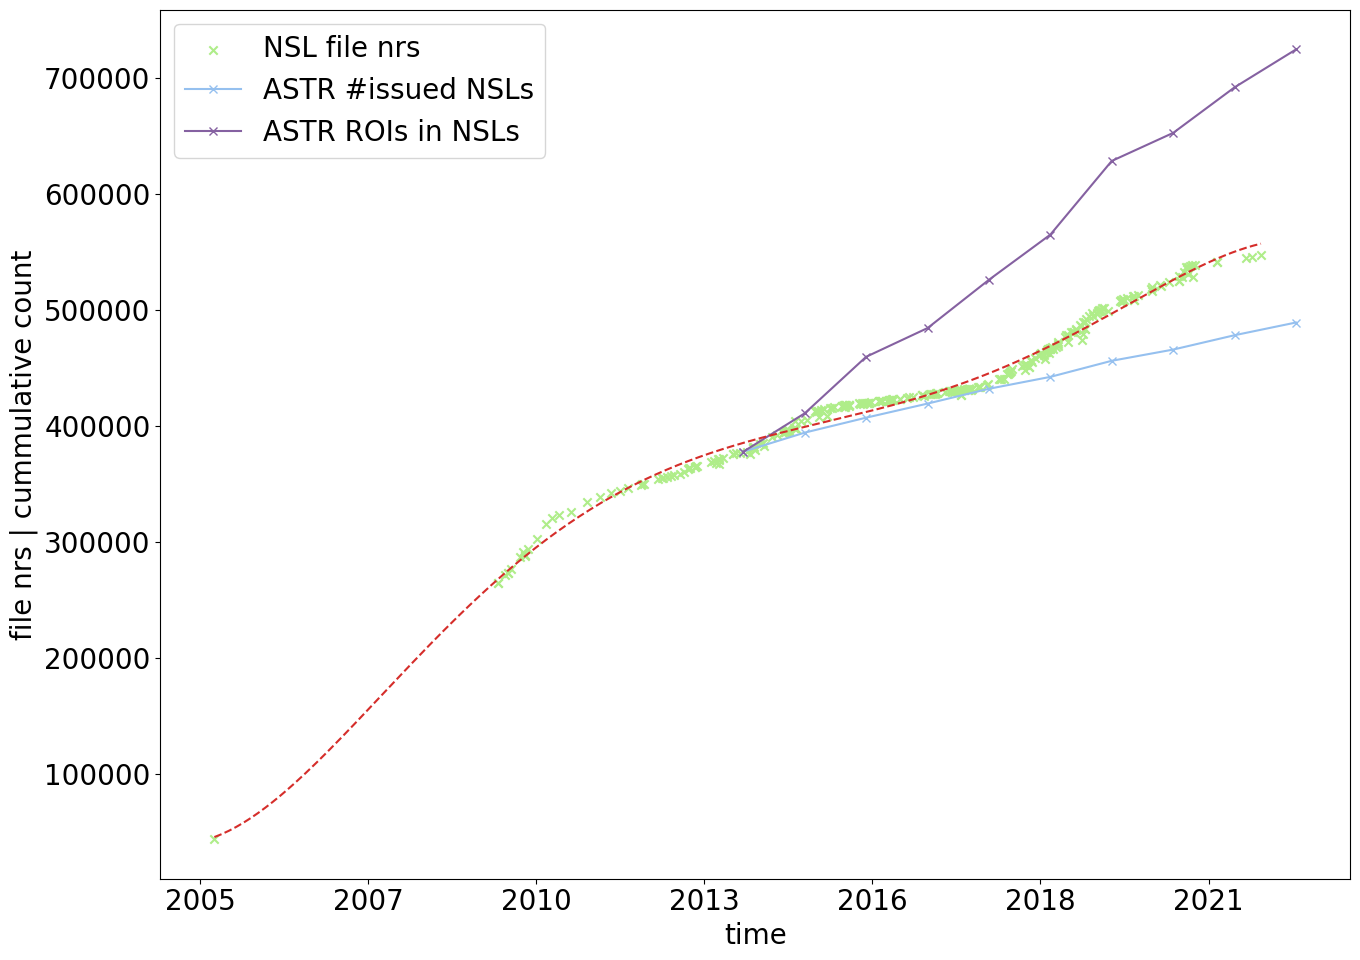

In [2]:
##### !!! TODO@Miro Check that the figure is the same as submitted !!! #####
##### !!! TODO@Miro Explain 377908 !!! #####


#!/usr/bin/python3
# This file plots the file number of issued NSLs
import json
import numpy as np
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
import os
from bs4 import BeautifulSoup
import requests
import time
from datetime import datetime

# Structured NSL Data
class NSL:
    def __init__(self, issue_date, nsl_file_number_only, year = None, release_date = None, link_to_nsl_file = None, link_to_release_letter = None):
        self.issue_date = issue_date
        self.nsl_file_number_only = nsl_file_number_only
        self.year = year  # Only available from NSLs released by Google
        self.release_date = release_date # Only available from NSLs released by Google
        self.link_to_nsl_file = None # Only available from NSLs released by Google
        self.link_to_release_letter = None # Only available from NSLs released by Google

    def __repr__(self):
        return self.__str__()

    def __str__(self):
        return f"NSL({self.nsl_file_number_only}, {self.issue_date.strftime('%Y-%m-%d')})"



# Directory where we store all html pages that contain links to nsl
DATA_DIR = "../../data/raw/google_nsl_pages"

# Get all raw html pages
files = sorted(os.listdir(DATA_DIR))
files = [f for f in files if '.html' in f]

nsls = []
# Process NSL Letters
for f in files:
    print('Processing ' + f)
    # read the raw html
    with open("{}/{}".format(DATA_DIR, f)) as fin:
        html = fin.read()
    # parse html
    soup = BeautifulSoup(html)
    
    # find the table that list nsl letters
    table = soup.find_all('table', class_='google-visualization-table-table')[-1]
    
    # record data for each nsl letter
    nsl_file_number = None
    nsl_file_url = None
    nsl_issue_date = None
    nsl_release_date = None
    nsl_release_url = None

    idx = 0
    for td in table.find_all('td'):
        if idx % 3 == 0:
            nsl_file_number = td.text
            nsl_file_url = td.find('a', href=True)['href']
        if idx % 3 == 1:
            nsl_issue_date = td.text
            # Convert to obj
            nsl_issue_date = datetime.strptime(nsl_issue_date, '%b %d, %Y')

        if idx % 3 == 2:
            nsl_release_date = td.text
            nsl_release_url = td.find('a', href=True)['href']
            if nsl_file_number in DATA_USED_IN_SUBMISSION:
                # Structure this data as object.
                nsl_file_number_only = nsl_file_number.split('-')[-1]
                nsls.append(NSL(nsl_issue_date, nsl_file_number_only, year = nsl_issue_date.year, release_date = nsl_release_date, link_to_nsl_file = nsl_file_url,link_to_release_letter = nsl_release_url))
        idx += 1


print("Got", len(nsls), "NSLs from Google")
# nsl data from nslarchive
# date, number
nslarchive_nsls = [
    ["2005-05-19", "43906"],
    ["2013-03-29", "365658"],
    ["2013-08-01", "371110"],
    ["2015-05-29", "415070"],
    ["2013-03-19", "364689"],
    ["2013-03-19", "364689"],
    ["2010-03-01", "272979"],
    ["2013-10-31", "375880"],
    ["2014-09-02", "394627"],
    ["2014-09-11", "395838"],
    ["2014-09-11", "396103"],
    ["2014-09-23", "396300"],
    ["2015-08-07", "417535"],
    ["2015-09-21", "418313"],
    ["2009-12-29", "264375"],
    ["2015-08-26", "417720"],
    ["2016-04-06", "421818"],
    ["2015-04-08", "413741"],
    ["2012-12-17", "358696"],
    ["2015-09-21", "418313"],
    ["2016-06-10", "422732"],
    ["2014-01-21", "377687"],
    ["2010-06-09", "287729"],
    ["2010-06-09", "288826"],
    ["2012-09-04", "355105"],
    ["2012-09-07", "355263"],
    ["2013-03-22", "365428"],
    ["2014-03-11", "379426"],
    ["2014-11-05", "398374"],
    ["2012-05-01", "349490"],
    ["2015-08-10", "417609"],
    ["2014-06-20", "390649"],
    ["2017-05-19", "430020"],
    ["2017-05-24", "429936"],
    ["2010-02-12", "271500"],
    ["2010-03-19", "276879"],
    ["2010-05-11", "287342"],
    ["2010-06-01", "291339"],
    ["2010-06-28", "293548"],
    ["2010-08-19", "302279"],
    ["2010-10-15", "315095"],
    ["2010-11-15", "320727"],
    ["2015-11-27", "419074"],
    ["2017-09-05", "431971"],
    ["2017-09-05", "431971"],
    ["2017-09-05", "431971"],
    ["2017-09-05", "431971"],
    ["2017-09-05", "431971"],
    ["2015-03-24", "407597"],
    ["2014-11-05", "397935"],
    ["2014-02-25", "380840"],
    ["2014-02-27", "381391"],
    ["2014-02-28", "381751"],
    ["2018-03-15", "440748"],
    ["2018-08-28", "450995"],
    ["2018-12-06", "463687"],
    ["2018-12-27", "466228"],
    ["2019-07-23", "483160"],
    ["2019-10-17", "499673"],
    ["2020-05-14", "508552"],
    ["2021-03-31", "531193"],
]

print("Got", len(nslarchive_nsls), "NSLs from nslarchive.org")

for nsl_issue_date, nsl_file_number_only in nslarchive_nsls:
    # convert to datetime obj
    nsl_issue_date = datetime.strptime(nsl_issue_date, '%Y-%m-%d')
    nsls.append(NSL(nsl_issue_date,nsl_file_number_only))

public_available_nsls_x_axis_issue_date = []
public_available_nsls_y_axis_nsl_number = []
for nsl in nsls:
    public_available_nsls_x_axis_issue_date.append(nsl.issue_date)
    # some nsl_file_number_only has (a) / (b). handle this situation
    vals = nsl.nsl_file_number_only.split("(")
    nsl_file_number_int = int(vals[0])
    
    # handle (a)/(b) in file name
    if len(vals) > 1:
        letter_nr = (ord(vals[1][:-1]) - ord("a"))/26
        nsl_file_number_int += letter_nr
    public_available_nsls_y_axis_nsl_number.append(nsl_file_number_int)

fisa_nsls_us = {
    2005: 9254,
    2006: 12583,
    2007: 16804,
    2008: 24744,
    2009: 14788,
    2010: 24287,
    2011: 16511,
    2012: 15229,
    2013: 14219,
    2014: 12453,
    2015: 9418,
    2016: 8727,
    2017: 9006,
    2018: 11454,
    2019: 8557,
    2020: 6670,
    2021: 7607,
    2022: 8587
}

fisa_nsls_req_non_us = {
    2015: 31863,
    2016: 6651,
    2017: 14861,
    2018: 14481,
    2019: 35848,
    2020: 6187,
    2021: 9486,
    2022: 9103
}

fisa_nsls_req_sub = {
    2015: 7361,
    2016: 9432,
    2017: 17712,
    2018: 12937,
    2019: 19601,
    2020: 11368,
    2021: 14732,
    2022: 14927
}

nsls_issued = {
    2013: 19212,
    2014: 16348,
    2015: 12870,
    2016: 12150,
    2017: 12762,
    2018: 10235,
    2019: 13850,
    2020: 9682,
    2021: 12362,
    2022: 10941
}

rois = {
    2013: 38832,
    2014: 33024,
    2015: 48642,
    2016: 24801,
    2017: 41579,
    2018: 38872,
    2019: 63466,
    2020: 24225,
    2021: 39214,
    2022: 32617
}

def get_cumulative_nsls_over_years(data, base_number_of_nsls=0):
    # start with base_number_of_nsls if not 0
    x_axis_time = []
    y_axis_total_nsls = []
    total_number_of_nsls = base_number_of_nsls
    for year, number in data.items():
        total_number_of_nsls += number
        x_axis_time.append(datetime(year=year, month=12, day=31))
        y_axis_total_nsls.append(total_number_of_nsls)
    return x_axis_time, y_axis_total_nsls

print("Processing NSL requests from FISA")
fisa_nsls_req = {}
for year, number_of_nsls_that_year in fisa_nsls_us.items():
    if year >= 2015:
        fisa_nsls_req[year] = number_of_nsls_that_year + fisa_nsls_req_non_us.get(year, 0) + fisa_nsls_req_sub.get(year, 0)

print("Processing Issued NSL")
astr_nsls_issued_x_axis_time, astr_nsls_issued_y_axis_cumulative_number = get_cumulative_nsls_over_years(nsls_issued, 377908-19212)

print("Processing ROIs")
astr_rois_in_nsls_x_axis_time, astr_rois_in_nsls_y_axis_cumulative_number = get_cumulative_nsls_over_years(rois, 377908-38832)


#
# Plotting (following guidelines of MP)
#
plt.rc("axes", axisbelow=True)

plt.rcParams["font.size"] = 20
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["figure.figsize"] = (14,10)
colors = ["#afed89", "#ffc1cc", "#ebc197", "#95c0ef", "#8561a1", 
            "#edc895", "#2c7707", "#9c9ed1", "#ccab0a"]

def to_ordinal(xs):
    return list(map(lambda x: x.toordinal(), xs))

# sort file numbers
public_available_nsls_x_axis_issue_date_ordinal = to_ordinal(public_available_nsls_x_axis_issue_date)
sorted_public_available_nsls_plotting_data = sorted(zip(public_available_nsls_x_axis_issue_date_ordinal, public_available_nsls_y_axis_nsl_number), key=lambda x: x[0])
public_available_nsls_x_axis_issue_date_sorted, public_available_nsls_y_axis_nsl_number_sorted = map(list, list(zip(*sorted_public_available_nsls_plotting_data)))

# Plotting the numbers acquired from different sources
fig, ax1 = plt.subplots()
# nsl numbers from publicly available nsl files
plt.scatter(public_available_nsls_x_axis_issue_date_sorted, public_available_nsls_y_axis_nsl_number_sorted, color=colors[0], marker="x", label="NSL file nrs")
# number reported in astar
plt.plot(to_ordinal(astr_nsls_issued_x_axis_time), astr_nsls_issued_y_axis_cumulative_number, colors[3], marker="x", label="ASTR #issued NSLs")
# rois reported in astar
plt.plot(to_ordinal(astr_rois_in_nsls_x_axis_time), astr_rois_in_nsls_y_axis_cumulative_number, colors[4], marker="x", label="ASTR ROIs in NSLs")


ax = plt.gca()
x_ticks = ax.get_xticks()

# add regression for file numbers
deg = 18
print(f"Use degree {deg} polyfit")
coeffs = np.polyfit(public_available_nsls_x_axis_issue_date_sorted, np.array(public_available_nsls_y_axis_nsl_number_sorted), deg=deg)
regression_x_values = np.linspace(public_available_nsls_x_axis_issue_date_sorted[0], public_available_nsls_x_axis_issue_date_sorted[-1], len(public_available_nsls_x_axis_issue_date_sorted))
regression_fitted_y_values = []
for x in regression_x_values:
    regression_fitted_y = 0
    for i, coeff in enumerate(coeffs):
        regression_fitted_y += x**(deg-i) * coeff
    regression_fitted_y_values.append(regression_fitted_y)
ax1.plot(regression_x_values, regression_fitted_y_values, linestyle="--", color="#d52d2a") #, label="NSL file nrs trend"

# set plot xticklabels
new_labels = [datetime.fromordinal(int(item)).year for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)

# Save
plt.xlabel("time")
plt.ylabel("file nrs | cummulative count")
plt.legend(loc="upper left")
plt.tight_layout()

OUTPUT_DATA_DIR = "../../data/processed/"
plt.savefig("{}/file_numbers.pdf".format(OUTPUT_DATA_DIR))
plt.savefig("{}/file_numbers.png".format(OUTPUT_DATA_DIR))